# CR model: Simple deletion of missing values does not work

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, quad, dblquad
import random

from bayesflow.networks import InvertibleNetwork 
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction  
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 11
time_points = np.linspace(0, 10, n_obs)
missing_max = 6

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [4]:
summary_net = LSTM(32)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR11_deletion_LSTM(32)_ckpts', skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_deletion_LSTM(32)_ckpts\ckpt-300


## Computational faithfulness

In [5]:
# Test data
param_prior = np.array([[-0.86260146, -1.0050269 ]])
result = [np.array([0.0245038 , 0.15066826, 0.21434814, 0.29709688, 0.34549964, 0.40176989, 0.43488455, 0.48059312, 0.48788007, 0.49382139,
                    0.51334028]),
          np.array([ 0,  1,  3,  5,  6,  7,  9, 10]),
          np.array([ 0.,  1.,  3.,  5.,  6.,  7.,  9., 10.])]

n_present = len(result[1])
x_data = np.ones((1, n_present, 1), dtype=np.float32)
x_data[0, :, 0] = result[0][result[1]]

# Sample from BayesFlow
n_post_samples = 7500   
param_samples = amortizer.sample(x_data, n_post_samples)   

In [6]:
def plot_marginal(ax, result, param_samples):  
    
    def prior_eval(x,y):   
        # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
        return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

    def likelihood(x,y):   
        # Calculates likelihood of available data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(result[2])
        residual = (result[0][result[1]] - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(x,y):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(x,y) * prior_eval(x,y)

    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, -2.25, 0.75, lambda y: -2.25, lambda y: 0.75)
    posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]
    
    # Compute marginal densities
    grid = 201
    A = np.linspace(-1.05, -0.45, grid)
    B = np.linspace(-1.45, -0.35, grid)
    bounds = np.array([-2.25, 0.75, -2.25, 0.75])
    
    ax[0].hist(param_samples[:, 0], bins='auto', density=1, color='orange', label='BayesFlow')
    marginal_x = np.zeros(grid)
    for i in range(grid):
        x = A[i]
        integrand_y = lambda y: posterior_xy(x, y)
        marginal_x[i] = quad(integrand_y, bounds[2], bounds[3])[0]
    ax[0].plot(A, marginal_x, label='True posterior')
    ax[0].set_ylabel('Marginal density')
    ax[0].set_xlabel('Parameter $k_1$')
    handles, labels = ax[0].get_legend_handles_labels()
    order = [1,0]
    ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    ax[0].set_title('                                                      Posterior distribution', loc='center', pad=6) 

    ax[1].hist(param_samples[:, 1], bins='auto', density=1, color='orange')
    marginal_y = np.zeros(grid)
    for j in range(grid):
        y = B[j]
        integrand_x = lambda x: posterior_xy(x, y)
        marginal_y[j] = quad(integrand_x, bounds[0], bounds[1])[0]
    ax[1].plot(B, marginal_y)
    ax[1].set_xlabel('Parameter $k_2$')

In [7]:
def predictive_check(ax, param_prior, result, param_samples, n_sim=501):

    for k in range(n_sim):
        rhs = lambda t,x: conversion_reaction(t, x, param_samples[k])
        sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)   
        if k == 0:
            ax.plot(np.array([0]), np.array([0]), color='grey', label='Simulation', linewidth=0.9)
        else: 
            ax.plot(sol.t, sol.y[1], color='grey', linewidth=0.5, alpha=0.2)
                
    rhs = lambda t,x: conversion_reaction(t, x, param_prior[0])
    sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
    ax.plot(sol.t, sol.y[1], color='black', label='True trajectory')    
    
    present_indices = result[1]
    missing_indices = np.setdiff1d(range(n_obs), present_indices)
    ax.plot(time_points[present_indices], result[0][present_indices], 'o', label='Available data')
    
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")
    ax.set_title('Posterior predictive check', loc='center', pad=6)
    handles, labels = ax.get_legend_handles_labels()
    order = [1,2,0]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

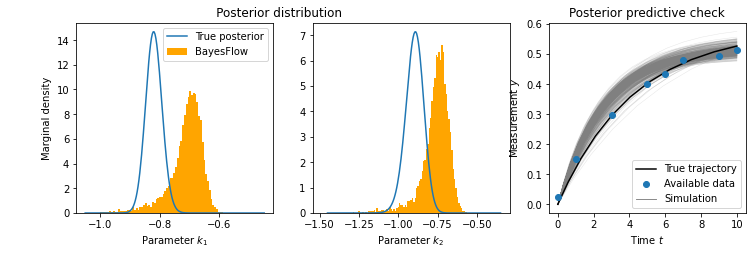

In [8]:
fig, ax = plt.subplots(1, 3, figsize=((12, 3.5)))
n_post_samples = 7500

plot_marginal(ax[0:2], result, param_samples)
predictive_check(ax[2], param_prior, result, param_samples)
fig.savefig("figures/deletion.png", dpi=300, bbox_inches='tight') 
fig.savefig("figures/deletion.pdf", bbox_inches='tight')